In [46]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [47]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

In [48]:
os.chdir('/content/drive/MyDrive/Conservatives-Official/Surface_Temperature/')

In [49]:
device = torch.device("cpu")

In [50]:
!pip install joblib

In [51]:
!pip install einops

In [52]:
!python /content/vision_transformer.py

In [53]:
import joblib
from vision_transformer import VisionTransformer

In [54]:
def min_max_normalization(input_array):
    min = input_array.min()
    max = input_array.max()
    return (input_array - min) / (max - min)

In [55]:
def load_ndvi_yield_data(pickle_path):
    try:
        # Load the pickled dictionary
        with open(pickle_path, 'rb') as f:
            ndvi_yield_preprocessed = pickle.load(f)
            ndvi = ndvi_yield_preprocessed["NDVI_Array"]
            yields = ndvi_yield_preprocessed["Yield"]
            ndvi_new = np.expand_dims(ndvi, axis=1)
            ndvi_normalized = min_max_normalization(ndvi_new)
        return ndvi_yield_preprocessed, ndvi_normalized, yields
    except FileNotFoundError:
        print(f"Error: File '{pickle_path}' not found.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [56]:
pickle_path = '/content/MyDrive/Conservatives-Official/Surface_Temperature/Pickle_Files'
ndvi_yield_preprocessed, ndvi_normalized, yields = load_ndvi_yield_data(pickle_path)

An error occurred: invalid load key, '\x03'.


TypeError: cannot unpack non-iterable NoneType object

In [57]:
# Define a custom dataset
class CustomDataset(Dataset):
  def __init__(self, data):
      self.data = data

  def __len__(self):
      return len(self.data)

  def __getitem__(self, idx):
      return self.data[idx]

In [58]:
def resnet50_features(input_array, batch_size):
    # Instantiate ResNet-50 model
    resnet = models.resnet50(weights=None)  # Load without pretrained weights
    resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    resnet.fc = nn.Identity()  # Remove the final fully connected layer

    # Assuming you have defined 'device' somewhere in your code
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    resnet.to(device)

    num_batches = len(input_array) // batch_size

    # Define the dataset and data loader
    dataset = CustomDataset(input_array)
    data_loader = DataLoader(dataset, batch_size=batch_size)

    # List to store concatenated feature vectors from all batches
    all_features = []

    # Set the model to evaluation mode
    resnet.eval()

    # Iterate over the data loader
    for batch_data in data_loader:
        # Pass the batch through ResNet-50
        with torch.no_grad():
            batch_features = resnet(batch_data.to(device, dtype=torch.float32))

        # Append the feature vectors for the current batch to the list
        all_features.append(batch_features)

    # Concatenate the feature vectors from all batches along the batch dimension
    concatenated_features = torch.cat(all_features, dim=0)
    feature_vectors = concatenated_features.detach().cpu().numpy()
    return feature_vectors

In [76]:
import pickle

# Assuming 'feature_vectors' contains your feature vectors
# Save feature vectors to a pickle file
with open('/content/drive/MyDrive/Conservatives-Official/Surface_Temperature/Pickle_Files/feature_vectors.pkl', 'wb') as f:
    pickle.dump(feature_vectors, f)

# Load feature vectors from the pickle file
with open('/content/drive/MyDrive/Conservatives-Official/Surface_Temperature/Pickle_Files/feature_vectors.pkl', 'rb') as f:
    loaded_feature_vectors = pickle.load(f)

In [61]:

import h5py
h5_data = h5py.File('/content/MyDrive/Conservatives-Official/Surface_Temperature/Pickle_Files/south_dakota_wheat.h5', 'r')
print(h5_data['features'])
input = np.array(h5_data['features'])
yields = np.array(h5_data['yield']).ravel()

<HDF5 dataset "features": shape (384, 100, 100), type "<f4">


In [62]:
ndvi_new = np.expand_dims(input, axis=1)
ndvi_normalized = min_max_normalization(ndvi_new)
ndvi_normalized.shape

(384, 1, 100, 100)

In [63]:
input_array = input.reshape((input.shape[0], 1, input.shape[1], input.shape[2]))
batch_size = 16
feature_vectors = resnet50_features(input_array, batch_size)
print("Extracted features shape:", feature_vectors.shape)

Extracted features shape: (384, 2048)


In [64]:
def train_and_evaluate_rf(features, yields, test_size=0.2, components=100):
    # Perform PCA
    pca = PCA(n_components=components)
    reduced_data = pca.fit_transform(features)

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(reduced_data, yields, test_size=test_size, random_state=24)

    # Initialize Random Forest regressor
    rf_regressor = RandomForestRegressor()

    # Train the model
    rf_regressor.fit(X_train, y_train)

    # Predict on the test set
    y_pred = rf_regressor.predict(X_test)

    # Calculate Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)
    print("Root Mean Squared Error:", mse**0.5)

    # Plot actual vs. predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Actual', color='blue')
    plt.plot(y_pred, label='Predicted', color='red')
    plt.title(f'Actual vs. Predicted Values for {components} components')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return trained model
    return rf_regressor

In [65]:
def save_trained_model(trained_model, model_filename, model_directory):
    try:
        # Construct the full path to the model file
        model_file_path = f"{model_directory}/{model_filename}"

        # Save the trained model
        joblib.dump(trained_model, model_file_path)
        print(f"Model saved successfully at: {model_file_path}")
    except Exception as e:
        print(f"An error occurred while saving the model: {e}")

Root Mean Squared Error: 8.728228222789566


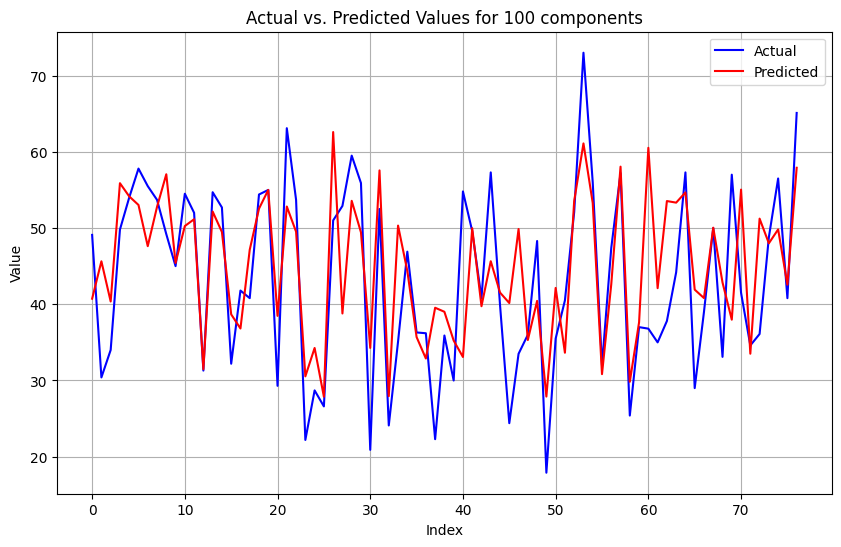

Model saved successfully at: /content/gdrive/MyDrive//trained_rf_model.pkl


In [66]:
trained_model = train_and_evaluate_rf(feature_vectors, yields)

model_filename = 'trained_rf_model.pkl'
model_directory = '/content/drive/MyDrive/Conservatives-Official/Surface_Temperature/Pickle_Files/'
save_trained_model(trained_model, model_filename, model_directory)